Processing Brasília, Brazil...
Processing Palmanova, Italy...
Processing Versailles, France...
Processing Karlsruhe, Germany...
Processing Canberra, Australia...
Processing Washington, D.C., USA...
Processing Ciudad Lineal, Spain...
Processing Manhattan, New York, USA...
Processing Chicago, USA...
Processing Greater London, UK...
Processing Amsterdam, Netherlands...
Processing Paris, France...
Processing Fez, Morocco...
Processing Old Delhi, India...
Processing Athens, Greece...
✅ Saved: comparisons/Centralized_Burst_vs_Brasília_Brazil.jpg
✅ Saved: comparisons/Radial_Convergence_vs_Palmanova_Italy.jpg
✅ Saved: comparisons/Radial_Implosion_vs_Versailles_France.jpg
✅ Saved: comparisons/Centralized_Ring_vs_Karlsruhe_Germany.jpg
✅ Saved: comparisons/Circled_Globe_vs_Canberra_Australia.jpg
✅ Saved: comparisons/Segmented_Radial_Convergence_vs_Washington_D.C._USA.jpg
✅ Saved: comparisons/Flow_Chart_vs_Ciudad_Lineal_Spain.jpg
✅ Saved: comparisons/Arc_Diagram_vs_Manhattan_New_York_USA.jpg
✅ Sav

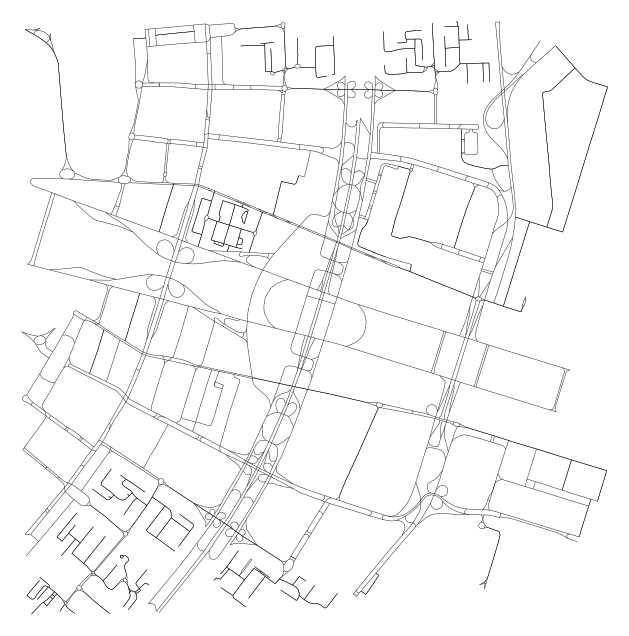

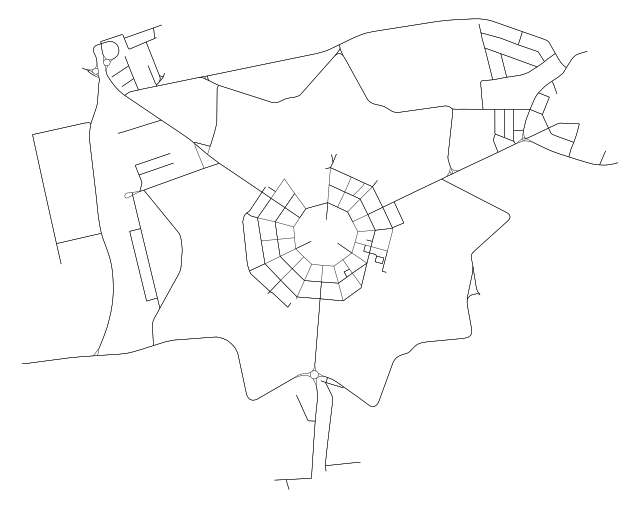

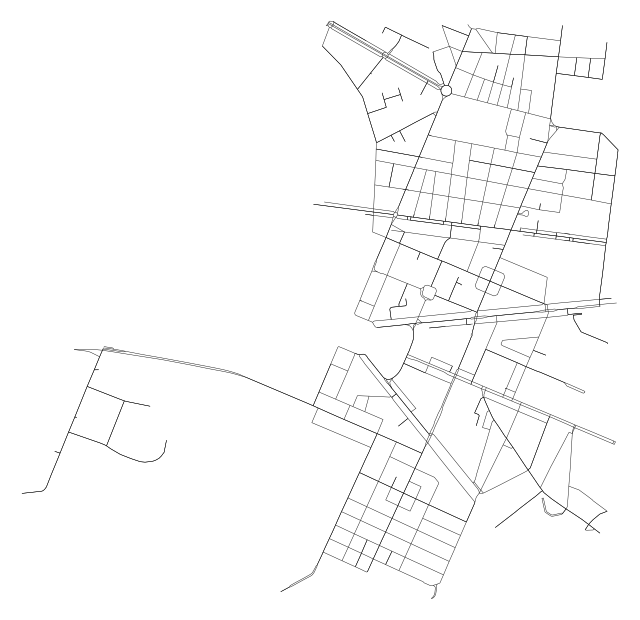

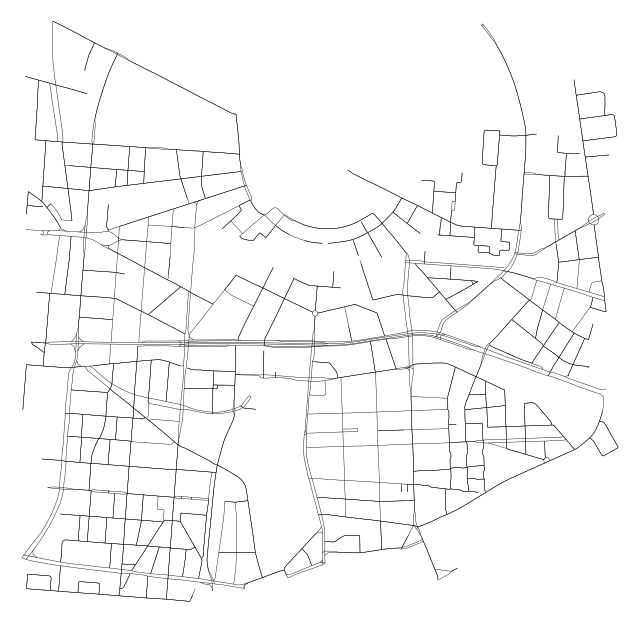

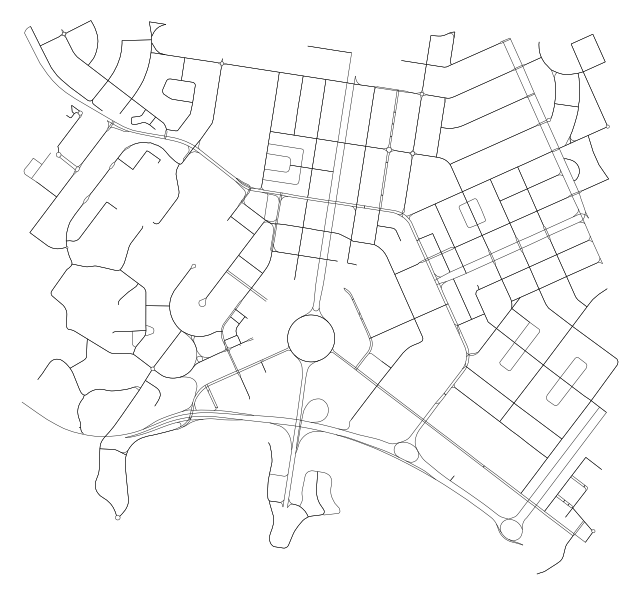

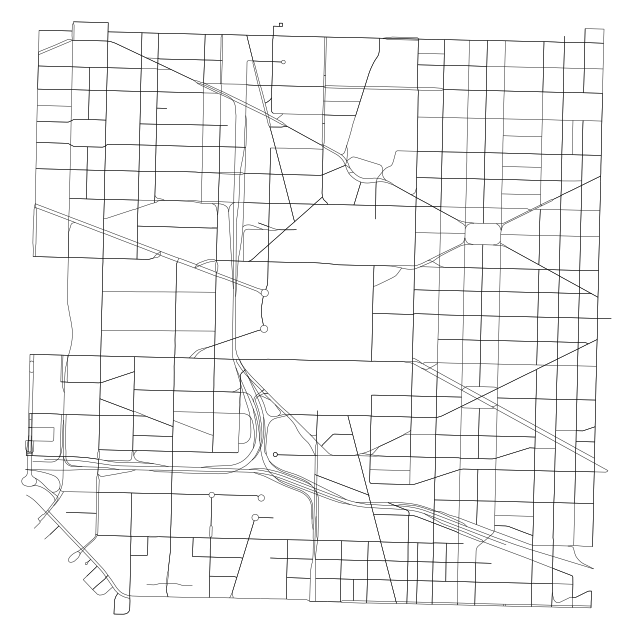

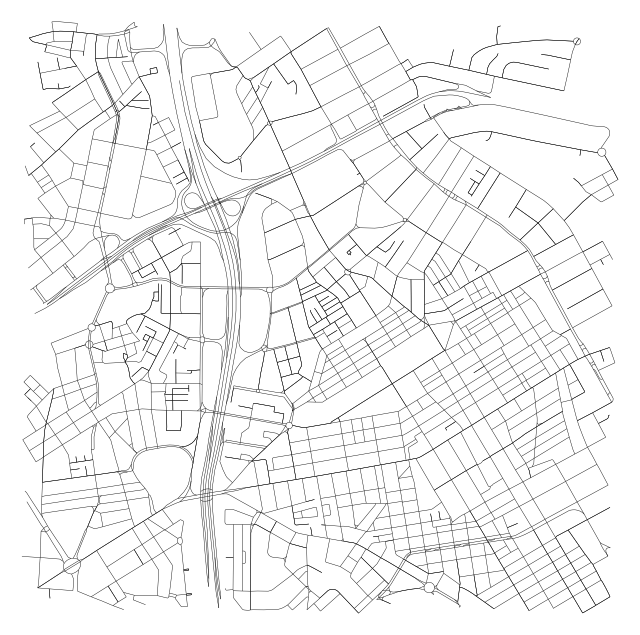

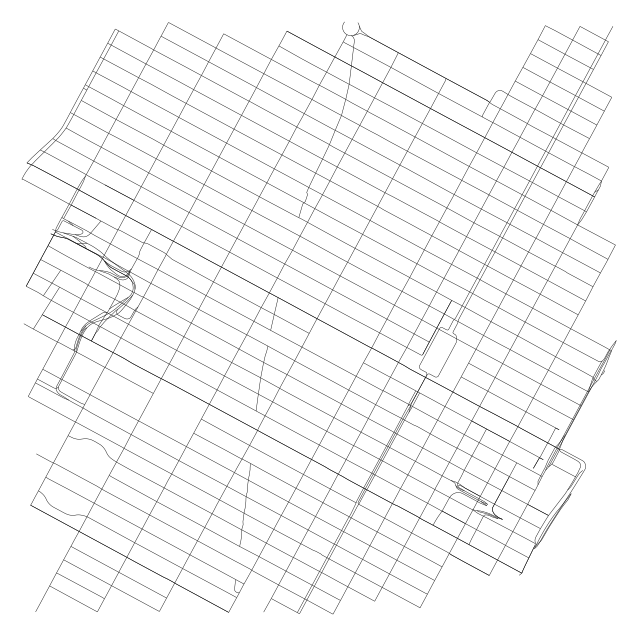

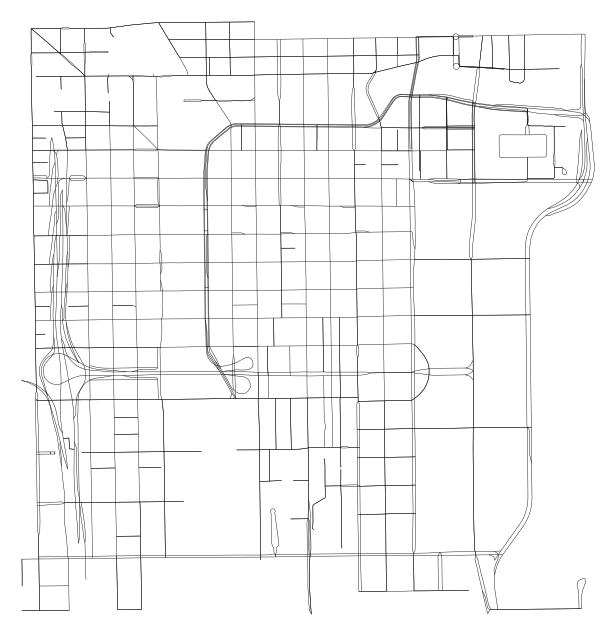

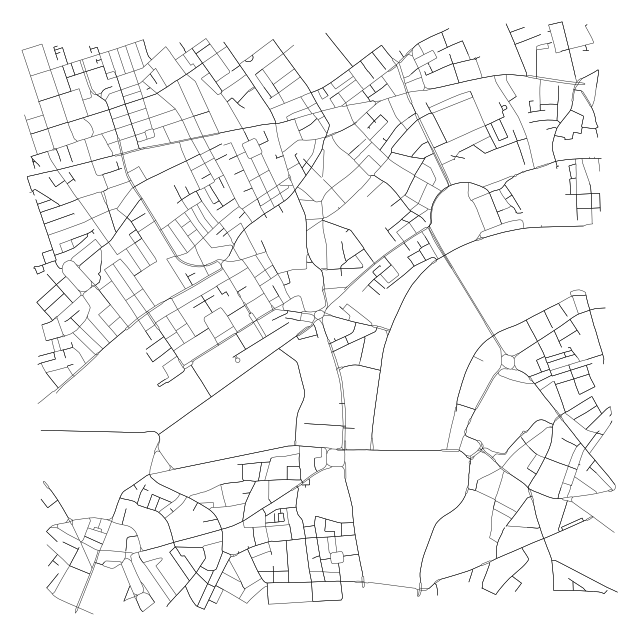

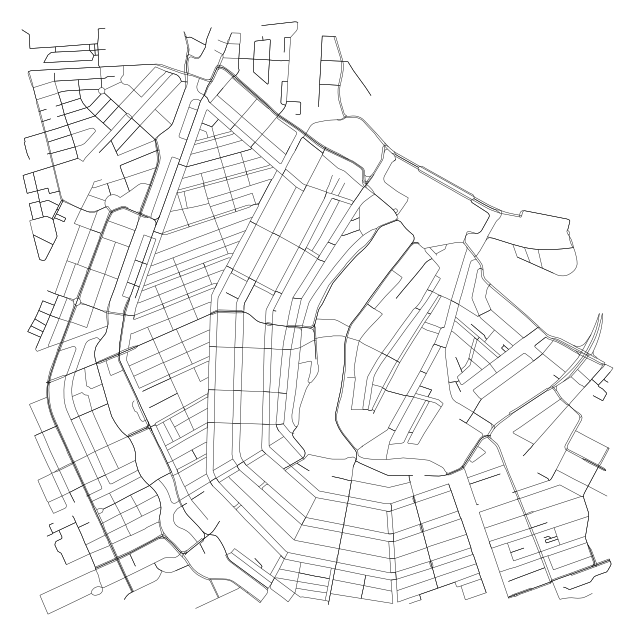

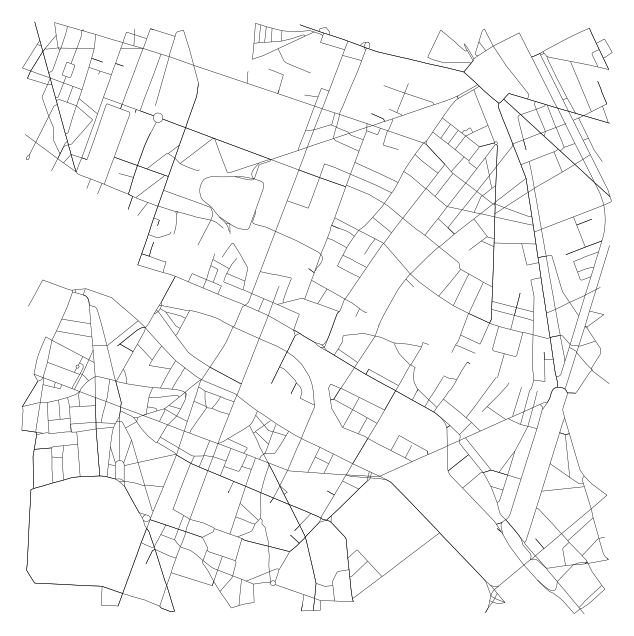

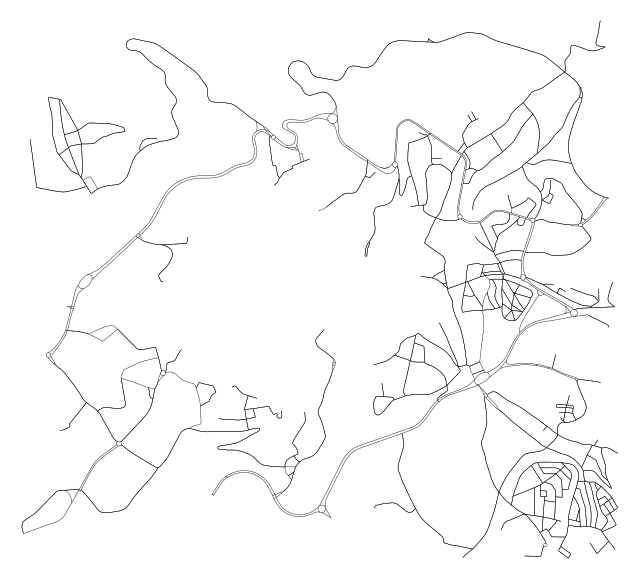

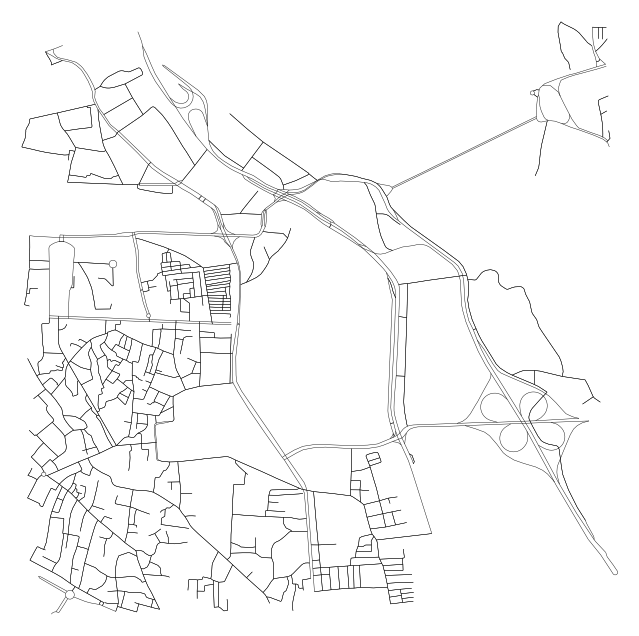

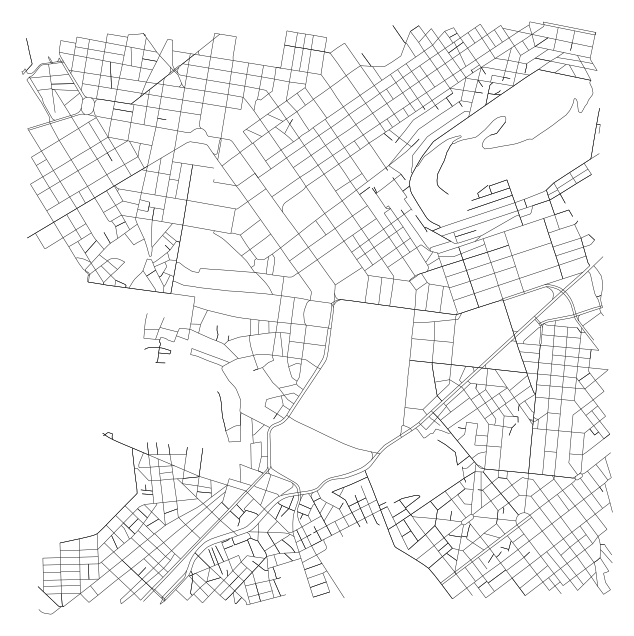

In [1]:
import os
from PIL import Image, ImageDraw, ImageFont
import osmnx as ox
import matplotlib.pyplot as plt

# Combined dataset of city names and coordinates
city_data = [
    {"name": "Brasília, Brazil", "coords": (-15.793889, -47.882778)},
    {"name": "Palmanova, Italy", "coords": (45.9061, 13.3095)},
    {"name": "Versailles, France", "coords": (48.8049, 2.1204)},
    {"name": "Karlsruhe, Germany", "coords": (49.0069, 8.4037)},
    {"name": "Canberra, Australia", "coords": (-35.2811, 149.1287)},
    {"name": "Washington, D.C., USA", "coords": (38.8899, -77.0091)},
    {"name": "Ciudad Lineal, Spain", "coords": (40.4395, -3.6540)},
    {"name": "Manhattan, New York, USA", "coords": (40.7549, -73.9840)},
    {"name": "Chicago, USA", "coords": (41.8781, -87.6300)},
    {"name": "Greater London, UK", "coords": (51.5072, -0.1276)},
    {"name": "Amsterdam, Netherlands", "coords": (52.3738, 4.8910)},
    {"name": "Paris, France", "coords": (48.8566, 2.3522)},
    {"name": "Fez, Morocco", "coords": (34.065, -4.973)},
    {"name": "Old Delhi, India", "coords": (28.6562, 77.2410)},
    {"name": "Athens, Greece", "coords": (37.9755, 23.7348)}
]

# Grouped mapping
grouped_pairs = {
    "Radial Power": [
        ("Centralized Burst", "Brasília, Brazil"),
        ("Radial Convergence", "Palmanova, Italy"),
        ("Radial Implosion", "Versailles, France")
    ],
    "Layered Hierarchies": [
        ("Centralized Ring", "Karlsruhe, Germany"),
        ("Circled Globe", "Canberra, Australia"),
        ("Segmented Radial Convergence", "Washington, D.C., USA")
    ],
    "Linear Flows": [
        ("Flow Chart", "Ciudad Lineal, Spain"),
        ("Arc Diagram", "Manhattan, New York, USA"),
        ("Elliptical Implosion", "Chicago, USA")
    ],
    "Modular Networks": [
        ("Area Grouping", "Greater London, UK"),
        ("Ramification", "Amsterdam, Netherlands"),
        ("Scaling Circles", "Paris, France")
    ],
    "Emergent Forms": [
        ("Organic Rhizome", "Fez, Morocco"),
        ("Circular Ties", "Old Delhi, India"),
        ("Sphere", "Athens, Greece")
    ]
}

# Create output folders
os.makedirs("images", exist_ok=True)
os.makedirs("comparisons", exist_ok=True)

# Generate city maps
for entry in city_data:
    city = entry["name"]
    coords = entry["coords"]
    filename = city.split(",")[0].replace(" ", "_") + ".png"
    filepath = os.path.join("images", filename)
    try:
        print(f"Processing {city}...")
        G = ox.graph_from_point(coords, dist=1500, network_type="drive")
        G_proj = ox.project_graph(G)
        ox.plot_graph(
            G_proj,
            bgcolor="white",
            node_color="black",
            node_size=0,
            edge_color="black",
            edge_linewidth=0.3,
            show=False,
            save=True,
            filepath=filepath,
            dpi=300
        )
    except Exception as e:
        print(f"⚠️ Failed to process {city}: {e}")

# Fonts for comparison panels
font_size = 20
title_font_size = 26
try:
    font = ImageFont.truetype("arial.ttf", font_size)
    title_font = ImageFont.truetype("arial.ttf", title_font_size)
except:
    font = ImageFont.load_default()
    title_font = ImageFont.load_default()

# Generate comparison images
thumb_size = (600, 600)
comparison_images = []

for group_name, items in grouped_pairs.items():
    for taxonomy_label, city_name in items:
        tax_file = os.path.join("taxonomy", f"{taxonomy_label}.jpg")
        city_file = os.path.join("images", f"{city_name.split(',')[0].replace(' ', '_')}.png")

        if not os.path.exists(tax_file):
            print(f"❌ Missing taxonomy image: {tax_file}")
            continue
        if not os.path.exists(city_file):
            print(f"❌ Missing city image: {city_file}")
            continue

        tax_img = Image.open(tax_file).convert("RGB").resize(thumb_size)
        city_img = Image.open(city_file).convert("RGB").resize(thumb_size)

        panel_width = 2 * thumb_size[0] + 3 * 40
        panel_height = thumb_size[1] + 3 * font_size + 80
        panel = Image.new("RGB", (panel_width, panel_height), "white")
        draw = ImageDraw.Draw(panel)

        x1, x2 = 40, thumb_size[0] + 2 * 40
        draw.text((panel_width // 2 - draw.textlength(group_name, font=title_font) // 2, 20),
                  group_name, font=title_font, fill="black")
        panel.paste(tax_img, (x1, 60))
        panel.paste(city_img, (x2, 60))
        draw.text((x1, 60 + thumb_size[1] + 10), taxonomy_label, font=font, fill="black")
        draw.text((x2, 60 + thumb_size[1] + 10), city_name, font=font, fill="black")

        filename = f"{taxonomy_label.replace(' ', '_')}_vs_{city_name.replace(', ', '_').replace(' ', '_')}.jpg"
        output_path = os.path.join("comparisons", filename)
        panel.save(output_path)
        comparison_images.append(panel)
        print(f"✅ Saved: {output_path}")

# Export to PDF
if comparison_images:
    pdf_output = "comparison.pdf"
    comparison_images[0].save(pdf_output, save_all=True, append_images=comparison_images[1:], format="PDF")
    print(f"\n📄 PDF exported to main folder: {pdf_output}")
else:
    print("⚠️ No images to compile into PDF.")